In [1]:
import pandas as pd
import numpy as np 
import os
from urllib.request import urlopen,urlretrieve
from PIL import Image
from sklearn.utils import shuffle
import cv2
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from keras.models import load_model
from sklearn.datasets import load_files   
from keras.utils import np_utils
from keras import applications
from keras.preprocessing.image import ImageDataGenerator 
from keras import optimizers
from keras.models import Sequential,Model,load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from keras.callbacks import TensorBoard,ReduceLROnPlateau,ModelCheckpoint

from keras.optimizers import SGD, Adam
from matplotlib import pyplot as plt
plt.style.use('default')

Using TensorFlow backend.


In [2]:
def data_preprocess(X_orig, Y_orig, G_orig):

    X = X_orig/255.  #X_test = X_test_orig/255.
# Convert training and test labels to one hot matrices
    Y = Y_orig  #Y_test = convert_to_one_hot(Y_test_orig, 6).T
    G = G_orig
    shuffle = np.random.permutation(np.arange(X.shape[0]))
    X, Y, G = X[shuffle], Y[shuffle], G[shuffle]
    
    i = int(0.8*X.shape[0])
    j = int(0.9*X.shape[0])


    X_train, Y_train, G_train = X[:i], Y[:i], G[:i]  # 8446*80% = 6758
    X_test, Y_test, G_test = X[i:j], Y[i:j], G[i:j]  # 10% test
    X_dev, Y_dev, G_dev = X[j:], Y[j:], G[j:]  # 10% dev

    print ("X_train shape: " + str(X_train.shape))
    print ("Y_train shape: " + str(Y_train.shape))
    print ("G_train shape: " + str(G_train.shape))
    print ("X_test shape: " + str(X_test.shape))
    print ("Y_test shape: " + str(Y_test.shape))
    print ("G_test shape: " + str(G_test.shape))
    print ("X_dev shape: " + str(X_dev.shape))
    print ("Y_dev shape: " + str(Y_dev.shape))
    print ("G_dev shape: " + str(G_dev.shape))

    return  X_train, Y_train, G_train, X_test, Y_test, G_test, X_dev, Y_dev, G_dev



def plot_learning_curves(history, log=True):
    '''
    Plot the model accuracy and loss learning curves for both the train and validation 
    data sets.
    '''
    fig, ax = plt.subplots(1, 2, figsize=(20,8))
    acy = history.history['accuracy']
    val_acy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acy_ylabel = 'accuracy'
    loss_ylabel = 'loss'
    
    if log:
        acy = np.log(acy)
        val_acy = np.log(val_acy)
        loss = np.log(loss)
        val_loss = np.log(val_loss)
        acy_ylabel = 'log accuracy'
        loss_ylabel = 'log loss'


  # Plot the RMSE 
    ax[0].plot(acy)
    ax[0].plot(val_acy)
    ax[0].set_title('Model performance')
    ax[0].set_ylabel(acy_ylabel)
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['train', 'val'], loc='upper right')

  # Plot the loss
    ax[1].plot(loss)
    ax[1].plot(val_loss)
    ax[1].set_title('Model loss')
    ax[1].set_ylabel(loss_ylabel)
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['train', 'val'], loc='upper right')
    
    plt.show()
    
    
def genre_group_add(genre_name, art_chrono, index, genre_group_list):
    
    '''
    generate item of the genre_group_list; genre_name, name of genre group(str);
    art_chrono, pd of art_data.sort_values(['years']); index, index in csv fror regarding artists for genre group;
    '''
    
    artist_id = list(art_chrono.iloc[index]['id'])  
    paint_no = art_chrono.iloc[index]['paintings'].sum()
    print(genre_name)
    print("Group artist: {}, paintings number {}".format(artist_id, paint_no))
    
    genre_group_list.append(artist_id)
    

def genre_labels(artist_labels, genre_group_list):
    
    genre_labels = np.zeros(len(artist_labels)) 
    
    for i in range(len(genre_group_list)):
        
        mask = np.isin(artist_labels, genre_group_list[i])
        genre_labels[mask] = i
        
    return genre_labels
    


## 0. Genre group

In [3]:
df = pd.read_csv('artists.csv')
art_data = df[['id', 'name', 'years', 'genre', 'nationality', 'paintings']]

art_chrono = art_data.sort_values(['years'])
art_chrono

,id,name,years,genre,nationality,paintings
23,23,Giotto di Bondone,1266 - 1337,Proto Renaissance,Italian,119
7,7,Andrei Rublev,1360 - 1430,Byzantine Art,Russian,99
29,29,Jan van Eyck,1395 - 1441,Northern Renaissance,Flemish,81
24,24,Sandro Botticelli,1445 - 1510,Early Renaissance,Italian,164
10,10,Hieronymus Bosch,1450 - 1516,Northern Renaissance,Dutch,137
26,26,Leonardo da Vinci,1452 - 1519,High Renaissance,Italian,143
19,19,Albrecht Dürer,1471 - 1528,Northern Renaissance,German,328
48,48,Michelangelo,1475 – 1564,High Renaissance,Italian,49
47,47,Raphael,1483 – 1520,High Renaissance,Italian,109
32,32,Titian,1488 - 1576,"High Renaissance,Mannerism",Italian,255


In [4]:
genre_group_list = []
genre_group_add('pro_rene', art_chrono, [0,1], genre_group_list)
genre_group_add('rene', art_chrono, list(range(2,12)), genre_group_list)
genre_group_add('baroque', art_chrono, list(range(12,16)), genre_group_list)
genre_group_add('roman', art_chrono, list(range(16,19)), genre_group_list)
genre_group_add('imp', art_chrono, [19, 21, 22, 23, 25, 26], genre_group_list)
genre_group_add('post_imp', art_chrono, [20, 24, 27, 28, 29, 30, 31, 32, 33, 34, 36, 41], genre_group_list)
genre_group_add('modern', art_chrono, [35, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49], genre_group_list)

print()
print(genre_group_list)

pro_rene
Group artist: [23, 7], paintings number 218
rene
Group artist: [29, 24, 10, 26, 19, 48, 47, 32, 21, 18], paintings number 1487
baroque
Group artist: [25, 14, 27, 31], paintings number 586
roman
Group artist: [16, 36, 39], paintings number 388
imp
Group artist: [34, 6, 30, 20, 3, 15], paintings number 1519
post_imp
Group artist: [35, 38, 40, 46, 8, 12, 41, 9, 37, 33, 28, 0], paintings number 2254
modern
Group artist: [1, 43, 11, 42, 13, 2, 22, 44, 4, 5, 17, 49, 45], paintings number 1994

[[23, 7], [29, 24, 10, 26, 19, 48, 47, 32, 21, 18], [25, 14, 27, 31], [16, 36, 39], [34, 6, 30, 20, 3, 15], [35, 38, 40, 46, 8, 12, 41, 9, 37, 33, 28, 0], [1, 43, 11, 42, 13, 2, 22, 44, 4, 5, 17, 49, 45]]


In [7]:
# X_orig = np.load('train_data.npy')
# Y_orig = np.load('train_labels.npy')

# G_orig = genre_labels(np.load('train_labels.npy'), genre_group_list)  # Genre Labels


### check G_orig completeness 

# for i in range(len(genre_group_list)):
#     print(i)
#     print(len(G_orig[G_orig==i]))

0
218
1
1487
2
586
3
388
4
1519
5
2254
6
1994


## 1a. Dataset train_data.npy (8446)

In [5]:
X_orig = np.load('train_data.npy')
Y_orig = np.load('train_labels.npy')
G_orig = to_categorical(genre_labels(np.load('train_labels.npy'), genre_group_list))

In [6]:
X_train, Y_train, G_train, X_test, Y_test, G_test, X_dev, Y_dev, G_dev = data_preprocess(X_orig, Y_orig, G_orig)

X_train shape: (6756, 256, 256, 3)
Y_train shape: (6756,)
G_train shape: (6756, 7)
X_test shape: (845, 256, 256, 3)
Y_test shape: (845,)
G_test shape: (845, 7)
X_dev shape: (845, 256, 256, 3)
Y_dev shape: (845,)
G_dev shape: (845, 7)


## 1b. genre_model (Resnet50)

In [7]:
## model 
img_height,img_width = 256, 256 
num_classes = len(genre_group_list) # default 7 genre groups number 
#If imagenet weights are being loaded, 
#input must have a static square shape (one of (128, 128), (160, 160), (192, 192), or (224, 224))
base_genre_model = applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= (img_height,img_width,3))

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [20]:
x = base_genre_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation= 'softmax')(x)
genre_model = Model(inputs = base_genre_model.input, outputs = predictions)

In [21]:
# sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
adam = Adam(lr=0.001)
genre_model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
history = genre_model.fit(X_train, G_train, epochs = 100, batch_size = 64, validation_data=(X_dev, G_dev))
genre_model.save('model_genre1b')

Train on 6756 samples, validate on 845 samples
Epoch 1/100
6756/6756 [==============================] - 193s 29ms/step - loss: 2.0099 - accuracy: 0.3341 - val_loss: 607.9164 - val_accuracy: 0.2296
Epoch 2/100
6756/6756 [==============================] - 175s 26ms/step - loss: 1.8109 - accuracy: 0.3530 - val_loss: 3.2609 - val_accuracy: 0.2320
Epoch 3/100
6756/6756 [==============================] - 176s 26ms/step - loss: 1.6897 - accuracy: 0.3606 - val_loss: 5.3744 - val_accuracy: 0.2947
Epoch 4/100
6756/6756 [==============================] - 176s 26ms/step - loss: 1.6616 - accuracy: 0.3612 - val_loss: 2.5165 - val_accuracy: 0.2923
Epoch 5/100
6756/6756 [==============================] - 176s 26ms/step - loss: 1.6121 - accuracy: 0.3743 - val_loss: 1.5996 - val_accuracy: 0.3645
Epoch 6/100
6756/6756 [==============================] - 175s 26ms/step - loss: 1.5528 - accuracy: 0.3927 - val_loss: 1.5670 - val_accuracy: 0.3870
Epoch 7/100
6756/6756 [==============================] - 176s 2

In [23]:
print(genre_model.evaluate(X_dev, G_dev))

845/845 [==============================] - 6s 7ms/step
[4.894894177250608, 0.388165682554245]


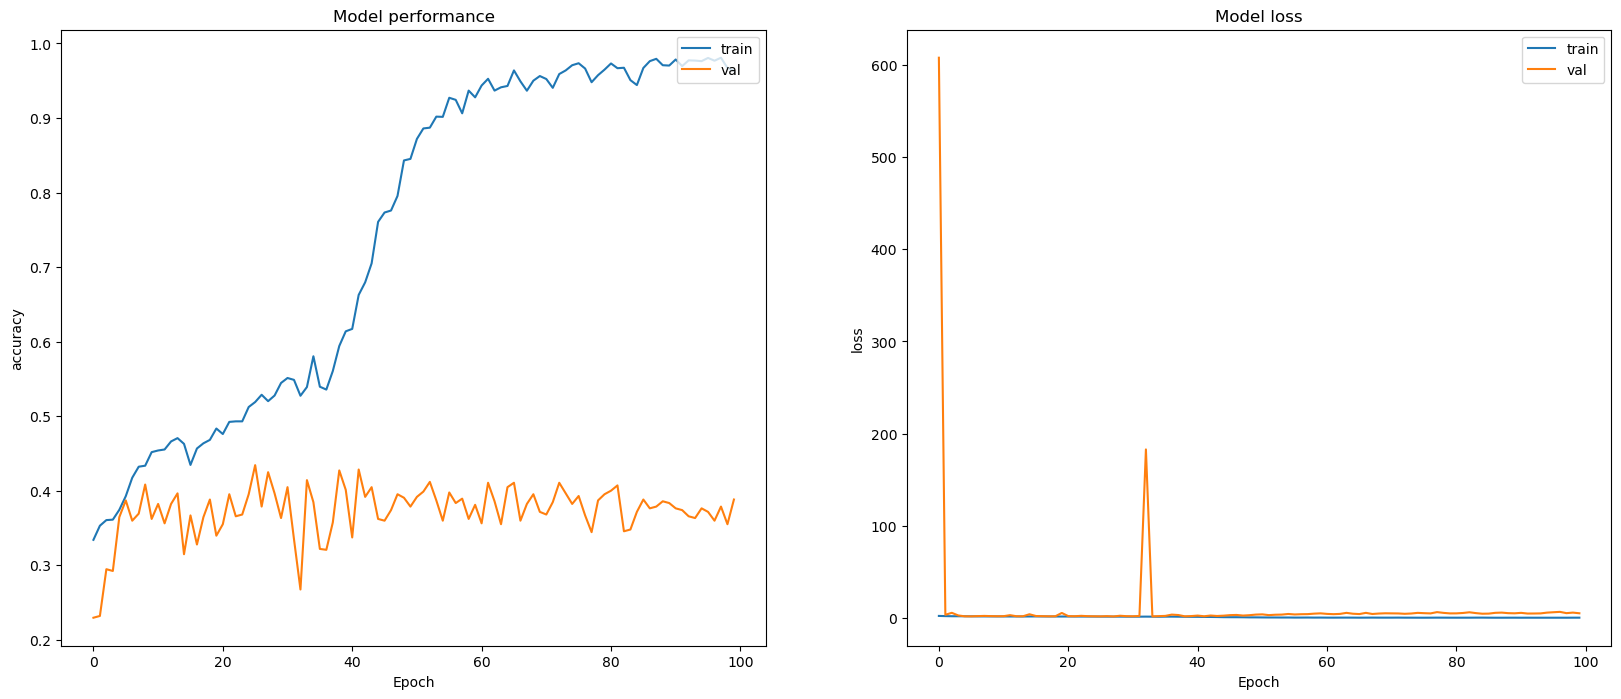

In [24]:
plot_learning_curves(history, False)

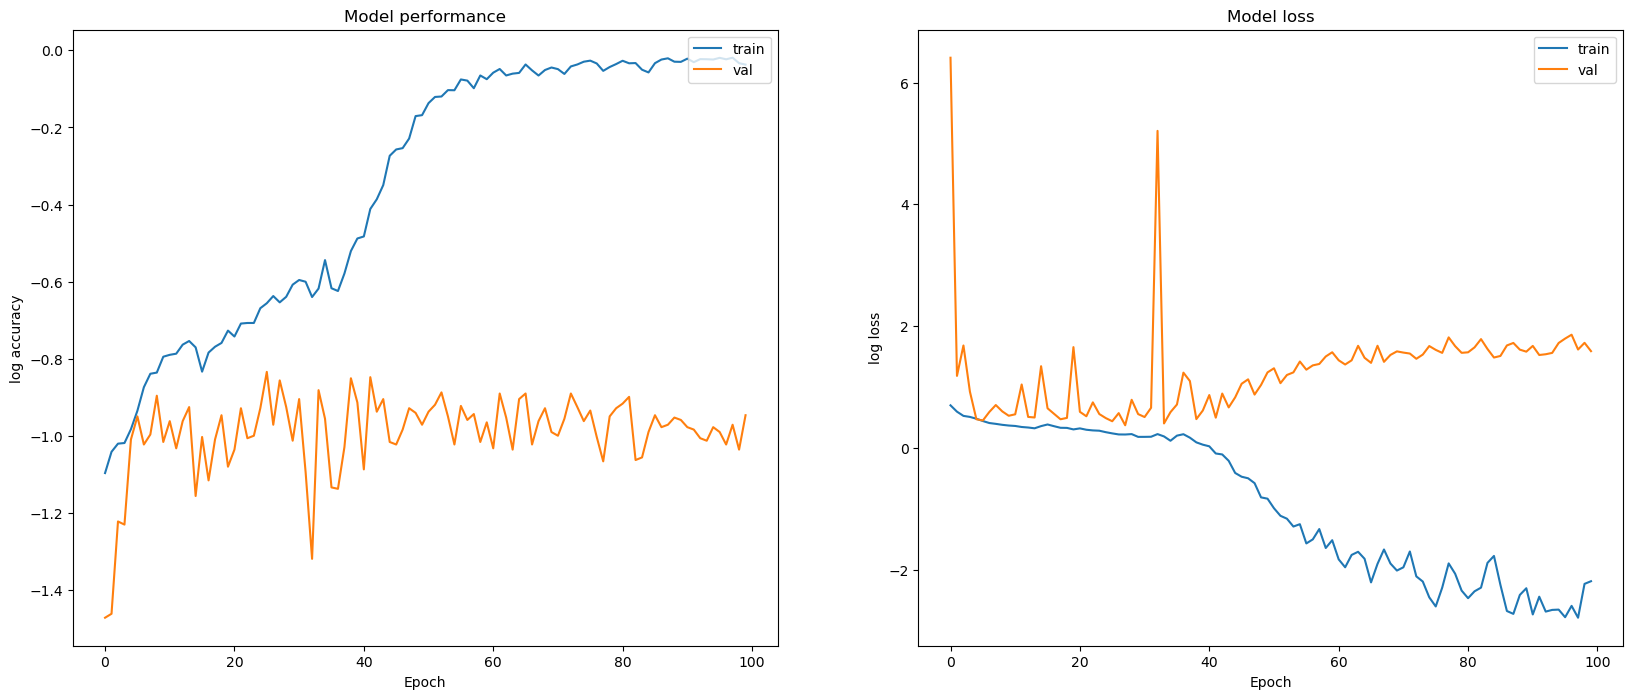

In [26]:
plot_learning_curves(history, True)

## (Resnet50)

In [7]:
## model 
img_height,img_width = 256, 256 
num_classes = len(genre_group_list) # default 7 genre groups number 
#If imagenet weights are being loaded, 
#input must have a static square shape (one of (128, 128), (160, 160), (192, 192), or (224, 224))
base_genre_model = applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= (img_height,img_width,3))

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [8]:
x = base_genre_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.9)(x)
predictions = Dense(num_classes, activation= 'softmax')(x)
genre_model = Model(inputs = base_genre_model.input, outputs = predictions)

In [9]:
# sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
adam = Adam(lr=0.001)
genre_model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = genre_model.fit(X_train, G_train, epochs = 100, batch_size = 64, validation_data=(X_dev, G_dev))
genre_model.save('model_genre1c')
plot_learning_curves(history, False)

model_temp = keras.models.load_model('model_genre1c')
print(genre_model.evaluate(X_dev, G_dev))

Train on 6756 samples, validate on 845 samples
Epoch 1/100
6756/6756 [==============================] - 201s 30ms/step - loss: 2.8897 - accuracy: 0.2627 - val_loss: 935.6065 - val_accuracy: 0.2686
Epoch 2/100
6756/6756 [==============================] - 175s 26ms/step - loss: 2.3391 - accuracy: 0.2772 - val_loss: 2.1063 - val_accuracy: 0.2710
Epoch 3/100
6756/6756 [==============================] - 176s 26ms/step - loss: 2.0523 - accuracy: 0.3139 - val_loss: 402.4405 - val_accuracy: 0.2533
Epoch 4/100
6756/6756 [==============================] - 175s 26ms/step - loss: 1.9392 - accuracy: 0.3178 - val_loss: 16.7316 - val_accuracy: 0.3124
Epoch 5/100
4224/6756 [=================>............] - ETA: 1:03 - loss: 1.7142 - accuracy: 0.3527

In [ ]:
model_temp = keras.models.load_model('model_genre1c')
print(genre_model.evaluate(X_dev, G_dev))

## 1b. MobileNet

In [7]:
## model 
img_height,img_width = 256, 256 
num_classes = len(genre_group_list) # default 7 genre groups number 
#If imagenet weights are being loaded, 
#input must have a static square shape (one of (128, 128), (160, 160), (192, 192), or (224, 224))
base_genre_model = applications.MobileNet(weights= None, include_top=False, input_shape= (img_height,img_width,3))

In [8]:
x = base_genre_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation= 'softmax')(x)
genre_model = Model(inputs = base_genre_model.input, outputs = predictions)

In [9]:
# sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
adam = Adam(lr=0.001)
genre_model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])

Train on 6756 samples, validate on 845 samples
Epoch 1/100
6756/6756 [==============================] - 111s 16ms/step - loss: 1.8148 - accuracy: 0.2957 - val_loss: 2.6267 - val_accuracy: 0.1834
Epoch 2/100
6756/6756 [==============================] - 99s 15ms/step - loss: 1.6760 - accuracy: 0.3345 - val_loss: 2.5334 - val_accuracy: 0.1834
Epoch 3/100
6756/6756 [==============================] - 100s 15ms/step - loss: 1.5860 - accuracy: 0.3620 - val_loss: 2.2482 - val_accuracy: 0.1834
Epoch 4/100
6756/6756 [==============================] - 99s 15ms/step - loss: 1.5352 - accuracy: 0.3881 - val_loss: 2.2530 - val_accuracy: 0.1834
Epoch 5/100
6756/6756 [==============================] - 99s 15ms/step - loss: 1.4977 - accuracy: 0.4047 - val_loss: 2.3142 - val_accuracy: 0.2639
Epoch 6/100
6756/6756 [==============================] - 100s 15ms/step - loss: 1.4627 - accuracy: 0.4264 - val_loss: 2.1758 - val_accuracy: 0.2107
Epoch 7/100
6756/6756 [==============================] - 99s 15ms/st

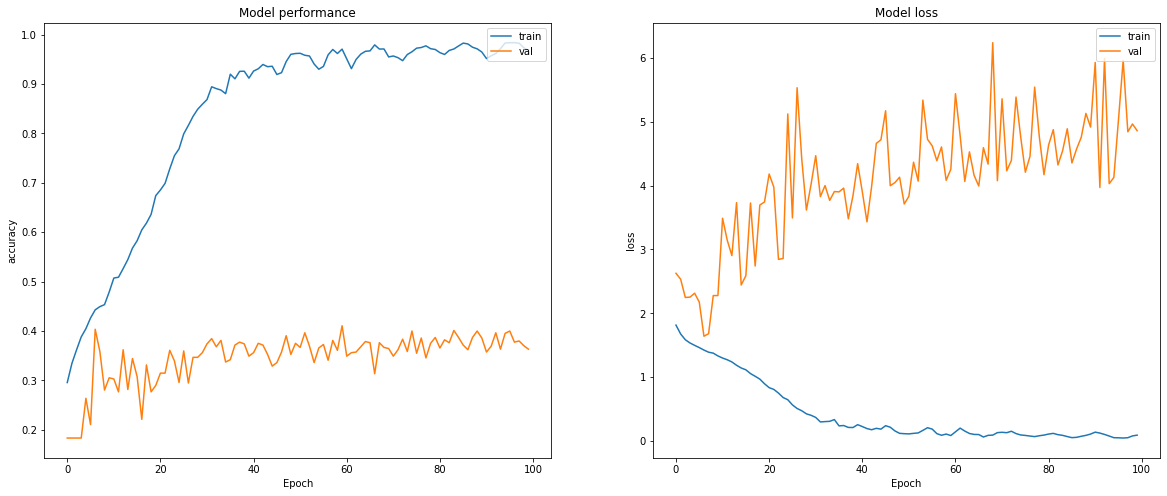

845/845 [==============================] - 3s 4ms/step
[4.860233108249642, 0.36331361532211304]


In [10]:
history = genre_model.fit(X_train, G_train, epochs = 100, batch_size = 64, validation_data=(X_dev, G_dev))
genre_model.save('model_genre1d')
plot_learning_curves(history, False)

model_temp = keras.models.load_model('model_genre1d')
print(genre_model.evaluate(X_dev, G_dev))

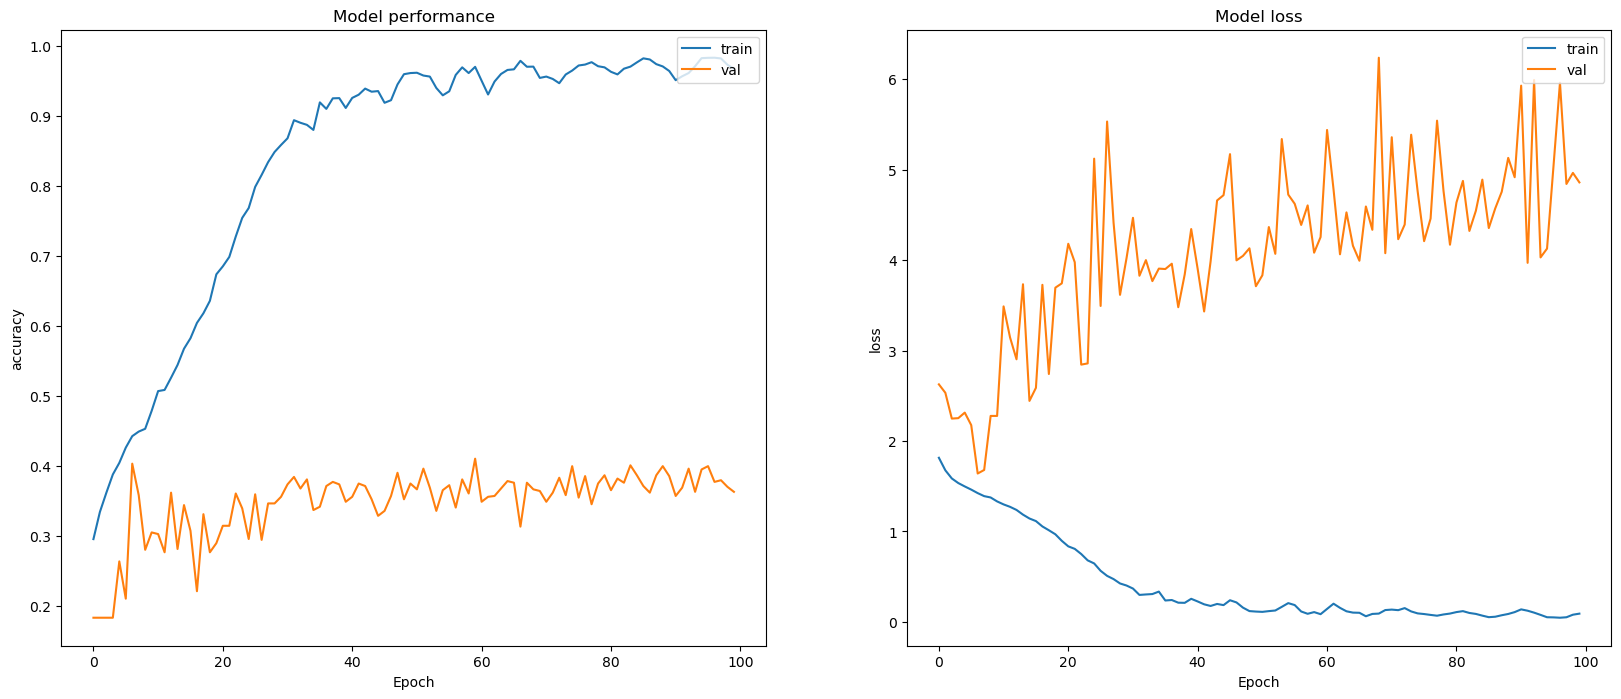

In [12]:
plot_learning_curves(history, False)

## 1.e MobileNet

In [10]:
## model 
img_height,img_width = 256, 256 
num_classes = len(genre_group_list) # default 7 genre groups number 
#If imagenet weights are being loaded, 
#input must have a static square shape (one of (128, 128), (160, 160), (192, 192), or (224, 224))
base_genre_model = applications.MobileNet(weights= None, include_top=False, input_shape= (img_height,img_width,3))

In [11]:
x = base_genre_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(num_classes, activation= 'softmax')(x)
genre_model = Model(inputs = base_genre_model.input, outputs = predictions)

In [15]:
# sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
adam = Adam(lr=0.0001)
genre_model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2)])

Train on 6756 samples, validate on 845 samples
Epoch 1/100
6756/6756 [==============================] - 107s 16ms/step - loss: 1.8887 - accuracy: 0.2734 - top_k_categorical_accuracy: 0.5007 - val_loss: 1.8334 - val_accuracy: 0.0615 - val_top_k_categorical_accuracy: 0.4860
Epoch 2/100
6756/6756 [==============================] - 99s 15ms/step - loss: 1.8035 - accuracy: 0.3131 - top_k_categorical_accuracy: 0.4916 - val_loss: 1.8581 - val_accuracy: 0.1822 - val_top_k_categorical_accuracy: 0.4973
Epoch 3/100
6756/6756 [==============================] - 99s 15ms/step - loss: 1.7780 - accuracy: 0.3287 - top_k_categorical_accuracy: 0.5018 - val_loss: 1.9242 - val_accuracy: 0.1822 - val_top_k_categorical_accuracy: 0.5035
Epoch 4/100
6756/6756 [==============================] - 99s 15ms/step - loss: 1.7374 - accuracy: 0.3296 - top_k_categorical_accuracy: 0.5067 - val_loss: 2.1103 - val_accuracy: 0.1822 - val_top_k_categorical_accuracy: 0.5098
Epoch 5/100
6756/6756 [=============================

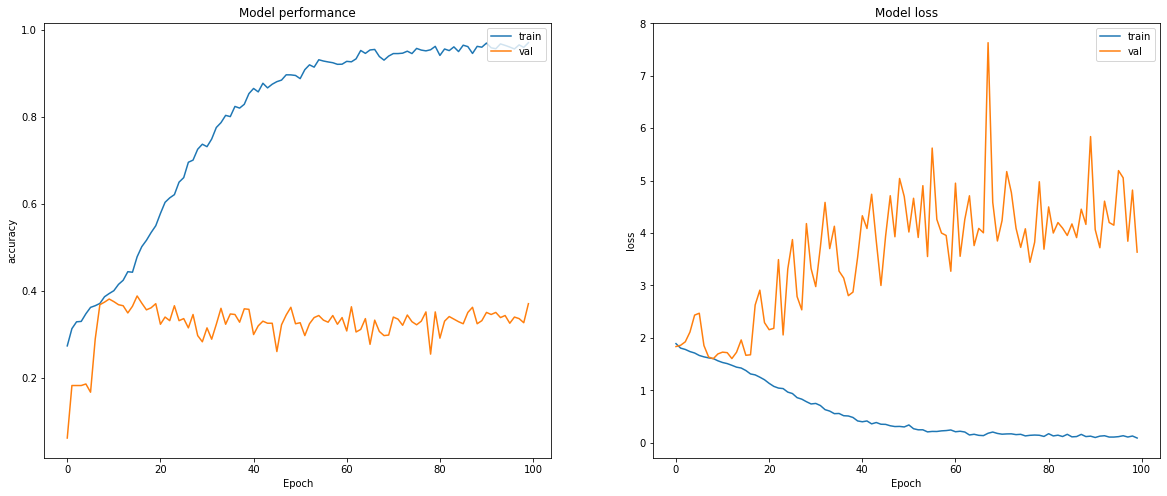

845/845 [==============================] - 3s 4ms/step
[3.634736879901773, 0.37041419744491577, 0.8518657088279724]


In [16]:
history = genre_model.fit(X_train, G_train, epochs = 100, batch_size = 64, validation_data=(X_dev, G_dev))
genre_model.save('model_genre1e')
plot_learning_curves(history, False)

model_temp = keras.models.load_model('model_genre1e')
print(genre_model.evaluate(X_dev, G_dev))

## 2. Dataset train_data_reshape(8446)

## 3. arg_4 (128,128)

## 4. Dataset train_data_arg6.npy (50676, 128, 128)

In [6]:
X6_orig = np.load('train_data_arg6.npy')
Y6_orig = np.load('train_labels_arg6.npy')
G6_orig = to_categorical(genre_labels(np.load('train_labels_arg6.npy'), genre_group_list))

In [ ]:
X6_train, Y6_train, G6_train, X6_test, Y6_test, G6_test, X6_dev, Y6_dev, G6_dev = data_preprocess(X6_orig, Y6_orig, G6_orig)

In [ ]:
# died each time 